## Chapter 3 - Performance evaluation

Panit (Luke) Arunanondchai

### Analyzing estimation output

The video has shown the analysis of goodness of fit in case of the Microsoft returns. Let's do a similar exercise for the daily EUR/USD returns. You need to analyze the estimation output for an AR(1)-GJR GARCH model with skewed student t distribution and then decide whether we need such a flexible model with AR(1) dynamics in the mean and leverage effect in the variance.

In [ ]:
# install.packages("MASS", repos = "https://cran.r-project.org/", dependencies=TRUE)

In [31]:
library(rugarch)

In [32]:
load("EURUSDret.Rdata")

In [34]:
# Specify model with AR(1) dynamics, GJR GARCH and skewed student t
flexgarchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                            variance.model = list(model = "gjrGARCH"),
                            distribution.model = "sstd")

# Estimate the model
flexgarchfit <- ugarchfit(data = EURUSDret, spec = flexgarchspec)

# Complete and study the statistical significance of the estimated parameters  
round(flexgarchfit@fit$matcoef,6)

,Estimate,Std. Error,t value,Pr(>|t|)
mu,-0.000018,0.000078,-0.232981,0.815776
ar1,0.000375,0.013994,0.026815,0.978607
omega,0.000000,0.000000,0.298360,0.765428
alpha1,0.034432,0.003336,10.320639,0.000000
beta1,0.968903,0.001252,773.972577,0.000000
gamma1,-0.010079,0.005810,-1.734675,0.082798
skew,1.014138,0.019566,51.831372,0.000000
shape,9.039540,1.345918,6.716266,0.000000


The skewed student t skewness parameter is statistically significantly different from zero. However 0 is not an interesting value to compare with for the skewness parameter. We should compare it with 1, since the the distribution is symmetric if the skewed student t skewenss parameter equals one. Here the estimated skewness parameter is 1.013 and its standard error equals 0.0195. The estimate is thus less than two standard errors away from one and thus we can conclude that the skewness parameter is one and that the distribution is thus symmetric.

### A better model for EUR/USD returns

In the previous exercise you have analyzed the statistical significance of the estimated parameters of the AR(1) GJR GARCH model with skewed student t distribution for the daily EUR/USD returns. The conclusion is that we should simplify the GARCH model used. Let's therefore take a constant mean standard GARCH model with student t distribution. We fix the mean value to zero and use variance targeting.

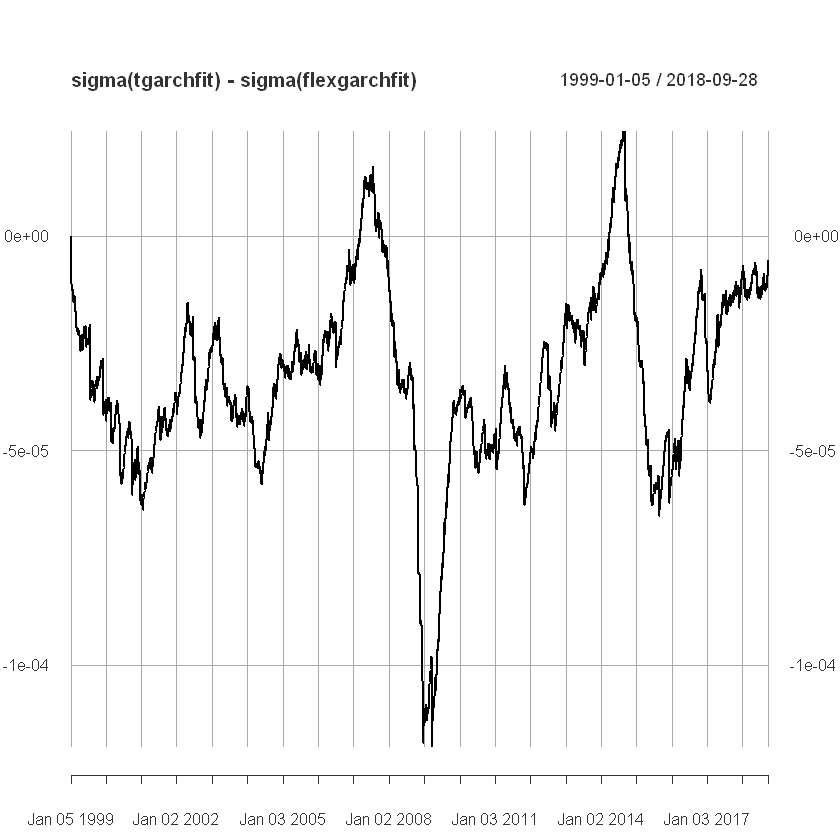

In [35]:
# Specify model with constant mean, standard GARCH and student t
tgarchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                         variance.model = list(model = "gjrGARCH", 
                         variance.targeting = TRUE),
                         distribution.model = "std")

# Fix the mu parameter at zero
 setfixed(tgarchspec) <- list("mu" = 0)

# Estimate the model
tgarchfit <- ugarchfit(data = EURUSDret, spec = tgarchspec)

# Verify that the differences in volatility are small
plot(sigma(tgarchfit) - sigma(flexgarchfit))

The volatilities seem similar.

By choosing the model with the highest likelihood, you will end up with the most complex model that is not parsimonious and has a high risk of overfitting.

### Mean squared prediction errors

The GJR GARCH model is a generalization of the GARCH model. It should thus lead to a better fit in terms of lower Mean Squared Errors (MSE). Let's verify this on the Microsoft returns msftret for which garchfit corresponds to the estimation with the standard GARCH(1,1) model, while gjrfit is when the GJR model is used. Remember that you can compute the vector with prediction errors e for the mean using the residuals() method. The prediction error for the variance equals the difference between e2 and the predicted GARCH variance.

In [42]:
load("msftret.Rdata")

garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                       variance.model = list(model = "sGARCH"),
                       distribution.model = "sstd")
garchfit <- ugarchfit(data=msftret, spec=garchspec)

gjrspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                       variance.model = list(model = "gjrGARCH"),
                       distribution.model = "sstd")
gjrfit <- ugarchfit(data=msftret, spec=gjrspec)

In [43]:
# Compute prediction errors
garcherrors <- residuals(garchfit)
gjrerrors  <- residuals(gjrfit)

# Compute MSE for variance prediction of garchfit model
mean((sigma(garchfit)^2 - garcherrors^2)^2)

# Compute MSE for variance prediction of gjrfit model
mean((sigma(gjrfit)^2 - gjrerrors^2)^2)

[1] 1.583428e-06

[1] 1.577262e-06

Note that the MSE of the GJR GARCH model is slightly lower than when the standard GARCH model is used. 

In [44]:
# Print the number of estimated parameters
length(coef(garchfit))
length(coef(gjrfit))

# Print likelihood of the two models
likelihood(garchfit)
likelihood(gjrfit)

# Print the information criteria of the two models
infocriteria(garchfit)
infocriteria(gjrfit)

[1] 6

[1] 8

[1] 13113.49

[1] 13126.92

,
Akaike,-5.484305
Bayes,-5.476180
Shibata,-5.484308
Hannan-Quinn,-5.481451


,
Akaike,-5.489087
Bayes,-5.478255
Shibata,-5.489092
Hannan-Quinn,-5.485282


The more simple model has a lower (more negative) information criterion and is therefore best for the daily EUR/USD returns.

### Correlogram and Ljung-Box test

Let's test the validity of a constant mean standard GARCH(1,1) model with student t distribution for the daily EUR/USD returns. The model is already estimated and available as tgarchfit.

[1] 0.00121956

[1] 1.005075


	Box-Ljung test

data:  abs(stdEURUSDret)
X-squared = 35.92, df = 22, p-value = 0.03097


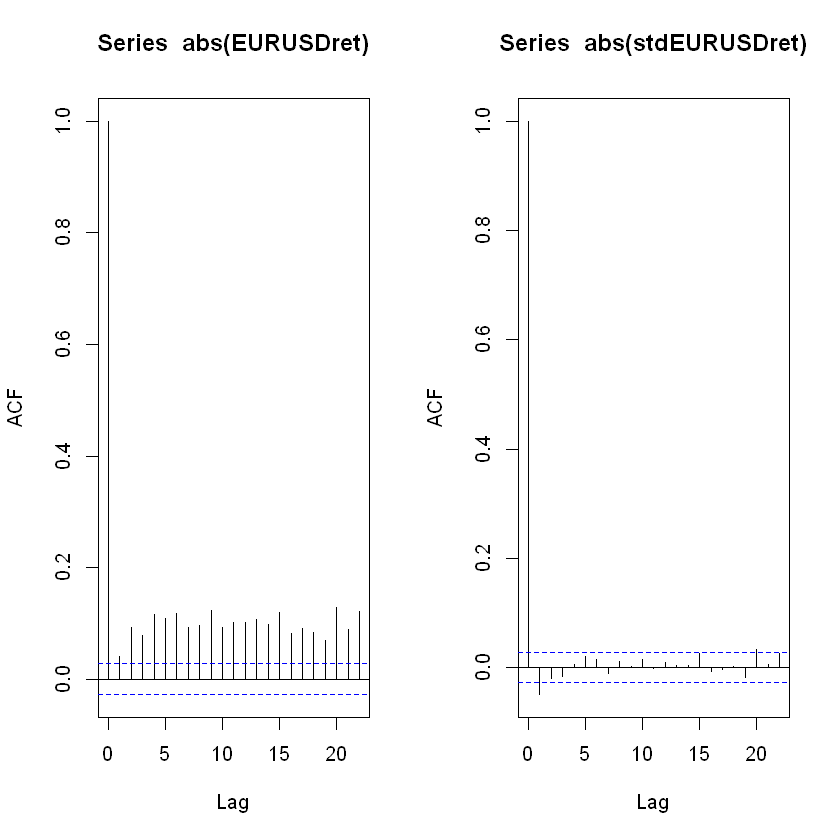

In [45]:
# Compute the standardized returns
stdEURUSDret <- residuals(tgarchfit, standardize = TRUE)

# Compute their sample mean and standard deviation
mean(stdEURUSDret)
sd(stdEURUSDret)

# Correlogram of the absolute (standardized) returns
par(mfrow = c(1, 2))
acf(abs(EURUSDret), 22)
acf(abs(stdEURUSDret), 22)

# Ljung-Box test
Box.test(abs(stdEURUSDret), 22, type = "Ljung-Box")

The Ljung-Box test concludes that at least one of the autocorrelations of order 1,…,22 is not zero. Therefore the model is not valid.

### Change estimation sample

There can be several causes for rejecting the validity of the GARCH model. It could be a wrong assumption for the mean, the variance or the distribution. It could also be that the time series of returns cannot be described by one set of GARCH parameters. In fact, given the dynamic nature of financial markets, it is realistic to expect that GARCH model parameters change through time. Let's therefore re-estimate our GARCH model on the 2500 most recent EUR/USD returns instead of doing the analysis on all 4961 returns.

In [46]:
# Estimate the model on the last 2500 observations
tgarchspec <- ugarchspec( mean.model = list(armaOrder = c(0,0)),
                        variance.model = list(model = "sGARCH"),
                        distribution.model = "std")
tgarchfit <- ugarchfit( data = tail(EURUSDret, 2500) , spec = tgarchspec)

# Compute standardized returns
stdEURUSDret <- residuals(tgarchfit, standardize = TRUE)

# Do the Ljung-Box test on the absolute standardized returns
Box.test(abs(stdEURUSDret), 22, type = "Ljung-Box")


	Box-Ljung test

data:  abs(stdEURUSDret)
X-squared = 27.986, df = 22, p-value = 0.1761


For the more recent data, we thus find that the GARCH model validity cannot be rejected. 

### ugarchroll arguments

The ugarchroll function is instrumental for rolling volatility prediction and avoiding look-ahead bias by conditioning the estimation to using only the returns available at the past time of estimation.

The ugarchroll gives the user flexibility in implementing the rolling estimation through the arguments n.start, refit.window and refit.every.

Which values should these arguments have in case the estimation sample consists of the 2000 most recent observations and the modeler only wants to re-estimate the model every 500 observations?

n.start = 2000, refit.window = "moving", refit.every = 500

you will estimate the model using a moving window sample of the 2000 most recently observed returns at each time of estimation. You reduce the computational cost by re-estimating the model every 500 observations instead of every single observation.

### In-sample versus rolling sample vol

For a given time series of returns, you can estimate the GARCH volatility using the method sigma() applied to the output from ugarchfit or by using the as.data.frame() method to the output from ugarchroll. The difference is that ugarchfit leads to an in-sample estimate of volatility obtained by estimating the GARCH model only once and using the complete time series, while ugarchroll re-estimates the model and uses only the returns that are actually observable at the time of estimation. In this exercise you need to compare the resulting volatility predictions for the daily S&P 500 returns using an AR(1) GJR GARCH model with skewed student t distribution. The GARCH specification to use is already specified and available as garchspec, while the data are in sp500ret.

In [59]:
load("sp500prices.Rdata")
# install.packages("PerformanceAnalytics", repos="https://cran.r-project.org/", dependencies=TRUE)
library(PerformanceAnalytics)

In [63]:
sp500ret = Return.calculate(xts(sp500prices),method="discrete")
sp500ret = tail(sp500ret, 4501)
garchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                       variance.model = list(model = "gjrGARCH"),
                       distribution.model = "sstd")

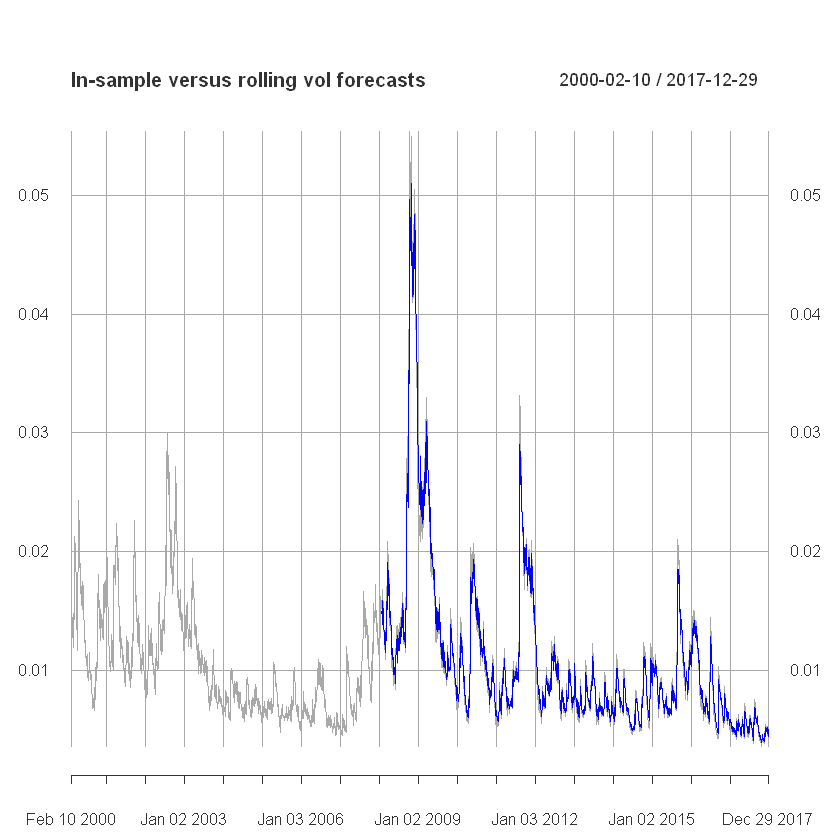

In [68]:
# Estimate the GARCH model using all the returns and compute the in-sample estimates of volatility
garchinsample <- ugarchfit(data = sp500ret, spec = garchspec)
garchvolinsample <- sigma(garchinsample)

# Use ugarchroll for rolling estimation of the GARCH model 
garchroll <- ugarchroll(garchspec, data = sp500ret , 
        n.start = 2000, refit.window = "moving",  refit.every = 2500)

# Set preds to the data frame with rolling predictions
preds <- as.data.frame(garchroll)

# Compare in-sample and rolling sample volatility in one plot
garchvolroll <- xts( preds$Sigma, order.by = as.Date(rownames(preds)))
volplot <- plot(garchvolinsample, col = "darkgrey", lwd = 1.5, main = "In-sample versus rolling vol forecasts")
volplot <- addSeries(garchvolroll, col = "blue", on = 1)
plot(volplot)

### Horse race

You are now asked to run a horse race in terms of forecasting accuracy between the two approaches for making rolling GARCH model predictions:

garchroll: AR(1) standard GARCH model and student t distribution
gjrgarchroll: AR(1) GJR GARCH model and skewed student t distribution.
The rolling estimations are implemented using

In [73]:
garchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                       variance.model = list(model = "sGARCH"),
                       distribution.model = "std")
garchroll <- ugarchroll(garchspec, data = sp500ret , 
        n.start = 2500, refit.window = "moving",  refit.every = 500)

gjrgarchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0)),
                       variance.model = list(model = "gjrGARCH"),
                       distribution.model = "sstd")
gjrgarchroll <- ugarchroll(gjrgarchspec, data = sp500ret , 
        n.start = 2500, refit.window = "moving",  refit.every = 500)

In [72]:
# Inspect the first three rows of the dataframe with out of sample predictions
garchpreds <- as.data.frame(garchroll)
head(garchpreds, 3)

# Compute prediction errors
e  <- garchpreds$Realized - garchpreds$Mu  
d  <- e^2 - garchpreds$Sigma^2 

# Compute MSE for the garchroll variance prediction
garchMSE <- mean(d^2)

# Compute MSE for gjrgarchroll
gjrgarchpreds <- as.data.frame(gjrgarchroll)
e  <- gjrgarchpreds$Realized - gjrgarchpreds$Mu
d  <- e^2 - gjrgarchpreds$Sigma^2
gjrgarchMSE <- mean(d^2)

,Mu,Sigma,Skew,Shape,Shape(GIG),Realized
2010-01-21,0.001197429,0.008286178,0,9.847798,0,-0.018944904
2010-01-22,0.001769581,0.009693708,0,9.847798,0,-0.022140988
2010-01-25,0.001988657,0.011382416,0,9.847798,0,0.004598098


Which interpretation is wrong?

This is wrong => For this application, the added flexibility of including a leverage effect and skewness in gjrgarchroll pays off in terms of forecasting accuracy compared to garchroll: the MSE computed on the out-of-sample predictions is 5.8% lower than the MSE of the standard GARCH model.

When doing rolling sample GARCH model predictions, the comparison is fair. You only use the returns available at the time of prediction. As such you are not exposed to look-ahead bias nor to overfitting, since the data used for the prediction is different from the actual return used to evaluate this prediction. The best predicting model wins. Depending on the application, the winner can be a simple model or a complex model.